In [1]:
import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
import pdb 
import time
import matplotlib.pyplot as plt

In [29]:
class FramesDataset(Dataset):
    '''
    @func preprocess
    @param path: relative path for the raw data
    @note raw data~ col1: frame index, col2: traj index, (col3, col4): (y, x)
    @return traj_list: indices for each trajactory in raw data
            participants_masks~tensor(frame num x traj num): indicate the presence of each ped at each frame
            file_data_tensors~tensor(frame num x traj num x 4): the position of each traj at each frame
                                                                if not present default to (0,0)
    '''
    def preprocess(self, path):
        #open the file as it is
        file_data = []
        with open(path, 'r') as file:
            for line in file:
                line_data = [int(float(data)) if i < 2 else float(data) for i, data in enumerate(line.rsplit())]
                line_data[2], line_data[3] = line_data[3], line_data[2]
                file_data.append(line_data)
#         file_data.sort(key=lambda data : data[0])   

        frame_num = file_data[0][0]
        data_temp = []    
        file_data_sort = sorted(file_data, key=lambda data : data[0])
        coord_data = []
        for line in file_data_sort:
            if frame_num != line[0]:
                frame_num = line[0]
                data_temp.sort(key=lambda data : data[0])
                coord_data.append(data_temp)
                data_temp = [line]
            else:    
                data_temp.append(line)
        
        #process the file data such that it contains the offsets not global coords
        file_data_off = []
        for i, line in enumerate(file_data):
            if i > 0:
                if file_data[i][1] == file_data[i-1][1]:
                    file_data_off.append([file_data[i][0], file_data[i][1], file_data[i][2]-file_data[i-1][2], file_data[i][3]-file_data[i-1][3]])
                    
        file_data_off.sort(key=lambda data : data[0])        
        
        #process the file data such that it's a list of lists of offset tuple in each time step
        file_data_t = []
        data_temp = []
        frame_num = file_data_off[0][0]
        traj_list = []
        frame_list = []
        for line in file_data_off:
            if frame_num != line[0]:
                frame_num = line[0]
                data_temp.sort(key=lambda data : data[1])
                file_data_t.append(data_temp)
                data_temp = [line]
            else:    
                data_temp.append(line)
            #keep a traj list for all trajs
            if line[1] not in traj_list:
                traj_list.append(line[1])
            if line[0] not in frame_list:
                frame_list.append(line[0])
        traj_list.sort()
        frame_list.sort()  

        #get participants in each frame
        #@note here the elements are ped's index in the traj list
        participants = [[] for i in range(len(file_data_t))]
        for frame_idx, line in enumerate(file_data_t):
            for traj_idx, traj in enumerate(traj_list):
                in_flag = False
                for data in line:
                    if data[1] == traj:
                        in_flag = True
                        participants[frame_idx].append(traj_list.index(data[1]))
                if not in_flag:
                    file_data_t[frame_idx].append([frame_list[frame_idx], traj, 0., 0.])
            file_data_t[frame_idx].sort(key=lambda data : data[1])

        file_data_tensors = torch.tensor(file_data_t, device=device)
        
        
        participant_masks = []
        for frame_idx, line in enumerate(participants):
            participant_masks.append([[torch.tensor(1.) if i in participants[frame_idx] else torch.tensor(0.) for i in range(len(traj_list))]])
        participant_masks = torch.tensor(participant_masks, device=device)
        
        return traj_list, participant_masks, file_data_tensors, coord_data

    def __init__(self, path):
        self.traj_list, self.participant_masks, self.file_data, self.coord_data = self.preprocess(path)

    def __len__(self):
        return len(self.file_data)

    '''
    @note (X, Y) is a (file_data[idx], frame[idx+1]) pair if a single idx is provided
    a (frame[idx.start]2frame[idx.end], frame[idx.start+1]2frame[idx.end+1]) pair is provided
    if a index slice is provided
    the accompanying mask tensor follows the same rule 
    '''
    def __getitem__(self, idx):
        if isinstance(idx, int):
            if idx < len(self.file_data)-1:
                Y_idx = idx+1
            else:
                Y_idx = len(self.file_data)-1

        else:
            if idx.start != None:
                start = idx.start+1
            else:
                start = 0+1
            if idx.stop != None:
                stop = idx.stop+1
            else:
                stop = len(self.file_data)-1
            Y_idx = slice(start, stop)

        participant_mask = self.participant_masks[idx]
        X = self.file_data[idx]
        Y = self.file_data[Y_idx]

        return participant_mask, (X, Y)

    def getTrajList(self):
        return self.traj_list

    def getParticipants(self):
        return self.participant_mask
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x = FramesDataset("try_dataset.txt")

In [3]:
class Phi(nn.Module):
    ''' a non-linear layer'''
    def __init__(self, dropout_prob):
        super(Phi, self).__init__()
        self.dropout_prob = dropout_prob
        self.ReLU = nn.ReLU()
        self.Dropout = nn.Dropout(p=dropout_prob)
    
    def forward(self, x):
        return self.Dropout(self.ReLU(x))


class VanillaLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=20, mediate_dim=10, output_dim=2, traj_num=3, dropout_prob=0.2):
        super(VanillaLSTM, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.traj_num = traj_num
        self.InputLayer = nn.Linear(input_dim, mediate_dim)
        self.LSTMCell = nn.LSTMCell(mediate_dim, hidden_dim)
        self.OutputLayer = nn.Linear(hidden_dim, output_dim)
        self.Phi = Phi(dropout_prob=dropout_prob)


    def forward(self, X, part_masks, all_h_t, all_c_t, Y, T_obs, T_pred):
        outputs = torch.empty(X.shape[0], X.shape[1], self.output_dim, device=device)
        for frame_idx, x in enumerate(X):      
            if frame_idx <= T_obs or frame_idx > T_pred:
                outputs[frame_idx] = torch.zeros(X.shape[1], self.output_dim)
                continue

            r = self.Phi(self.InputLayer(x[:,2:]))
            all_h_t, all_c_t = self.LSTMCell(r, (all_h_t, all_c_t))
            part_mask = torch.t(part_masks[frame_idx]).expand(part_masks[frame_idx].shape[1], self.output_dim)
            outputs[frame_idx] = self.OutputLayer(all_h_t) * part_mask

            if frame_idx > 3:
                for traj_idx in torch.where(part_masks[frame_idx][0] != 0)[0]:
                    if part_masks[frame_idx-3][0][traj_idx] == 0:
                        outputs[frame_idx, traj_idx] = Y[frame_idx, traj_idx] 

        return outputs

In [53]:
def train(T_obs, T_pred):
    tic = time.time()
    
    h_dim = 128
    batch_size = T_pred

    #try to train this
#     dataset = FramesDataset("crowds_zara02.txt")
    dataset = FramesDataset("try_dataset.txt")
    #a dataloader for now not sure how to use
    dataloader = DataLoader(dataset, batch_size=batch_size)

    traj_num = len(dataset.getTrajList())
    h = torch.zeros(traj_num, h_dim, device=device)
    c = torch.zeros(traj_num, h_dim, device=device)

    vl = VanillaLSTM(hidden_dim=h_dim, mediate_dim=100, output_dim=2, traj_num=traj_num)
    vl.to(device)

    #define loss & optimizer
    criterion = nn.MSELoss(reduction="sum")
    # criterion = Gaussian2DNll
    optimizer = torch.optim.Adagrad(vl.parameters(), weight_decay=0.0005)

    print("training")
    plot_data = [[] for _ in range(len(dataset) // batch_size)]
    print(f"len {len(dataset)} batch_size {batch_size} len {len(plot_data)}")
    #sequentially go over the dataset batch_size by batch_size
    for epoch in range(100):
        for batch_idx, (part_masks, (input_seq, Y)) in enumerate(dataloader):
            if batch_idx < len(dataset) // batch_size:
                Y = Y[:,:,2:]
                with torch.autograd.set_detect_anomaly(True):         
                    #forward prop
                    output = vl(input_seq, part_masks, h, c, Y, T_obs, T_pred)

                    #compute loss
                    Y_pred = output[T_obs+1:T_pred]
                    Y_g = Y[T_obs+1:T_pred]

                    cost = criterion(Y_pred, Y_g)

                    if epoch % 10 == 9:
                        print(epoch, batch_idx, cost.item())

                    #save data for plotting
                    plot_data[batch_idx].append(cost.item())

                    #backward prop
                    optimizer.zero_grad()
                    cost.backward()
                    optimizer.step()

    toc = time.time()
    print(f"training consumed {toc-tic}\n")

    #plot the cost
    plt.figure()
    for data in plot_data:
        plt.plot(np.arange(len(plot_data[0])), data)
#     plt.savefig("ninb.png")
    
    #save the model
    torch.save(vl, "vl.pt")
    print("saved model")    

    return vl

train(12,20)

training
len 39 batch_size 20 len 1
9 0 2.0302164554595947
19 0 1.8203184604644775
29 0 1.706946611404419
39 0 1.6120009422302246


KeyboardInterrupt: 

In [60]:
def validate(model, T_obs, T_pred):
    #try to validate this
    h_dim = 128

    batch_size = T_pred

#     dataset = FramesDataset("crowds_zara02.txt")
    dataset = FramesDataset("try_dataset.txt")    
    #a dataloader for now not sure how to use
    dataloader = DataLoader(dataset, batch_size=batch_size)

    traj_num = len(dataset.getTrajList())
    h = torch.zeros(traj_num, h_dim, device=device)
    c = torch.zeros(traj_num, h_dim, device=device)
    #validate the model based on the dataset
    for batch_idx, (part_masks, (input_seq, Y)) in enumerate(dataloader):
        if batch_idx < len(dataset) // batch_size:
            Y = Y[:,:,2:]
            with torch.autograd.set_detect_anomaly(True):         
                print(f"batch {batch_idx}")
                #forward prop
                output = model(input_seq, part_masks, h, c, Y, T_obs, T_pred)

                #compute loss
                Y_pred = output[T_obs+1:T_pred]
                Y_g = Y[T_obs+1:T_pred]

#                 dists_list = [np.array([]) for _ in range(traj_num)]
#                 batch_parts = []
#                 for frame_idx, (y_pred, y_g) in enumerate(zip(Y_pred, Y_g)):
#                     for traj_idx in range(part_masks[frame_idx].shape[1]):
#                         if part_masks[frame_idx+T_obs+1][0][traj_idx] != 0:
#                             if traj_idx not in batch_parts:
#                                 batch_parts.append(traj_idx)
#                             dist = torch.dist(y_pred[traj_idx],y_g[traj_idx]).item()
#                             print(f"at frame {frame_idx+T_obs+1} ped {traj_idx} is off by {dist}\n")
#                             dists_list[traj_idx] = np.append(dists_list[traj_idx], dist)
                
#                 total_ADE = np.array([])
#                 total_FDE = np.array([])
#                 for batch_part in batch_parts:
#                     ADE = np.average(dists_list[batch_part])
#                     print(f"ADE of traj {batch_part} {ADE}")
#                     total_ADE = np.append(total_ADE, ADE)
#                     print(f"FDE of traj {batch_part} {dists_list[batch_part][-1]}")
#                     total_FDE = np.append(total_FDE, dists_list[batch_part][-1])
#                     print("------------------------------------------------------")

#                 print(f"total ADE {np.average(total_ADE)}")
#                 print(f"total FDE {np.average(total_FDE)}")
#                 print("================================================================")

                if batch_idx == 0:
                    plotting_data0 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx, dataset.coord_data)
                elif batch_idx == 15:
                    plotting_data15 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx) 
                elif batch_idx == 30:
                    plotting_data30 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx)                           
    
    plotting_batch(*plotting_data0)
    plotting_batch(*plotting_data15)  
    plotting_batch(*plotting_data30)        

In [62]:
'''
@param trajs~(frame_num of a batch x traj_num x 2)
'''
def plotting_batch(total_trajs, batch_trajs, part_masks, traj_num, batch_idx, coord_data):
    for i, l in enumerate(total_trajs):
        print(i)
        print(l)
        print("-------------------")
    print("\n")
    for line in coord_data:
        print(line)
    
    #reform the trajs tensor to a list of each traj's pos at each frame
    batch_trajs_pred = batch_trajs[0].cpu().data.numpy()
    batch_trajs_g = batch_trajs[1].cpu().data.numpy()
    trajs_pred_list = [np.array([]) for _ in range(traj_num)]
    trajs_g_list = [np.array([]) for _ in range(traj_num)]
    parts = []
    for frame_idx, (trajs_pred, trajs_g) in enumerate(zip(batch_trajs_pred, batch_trajs_g)):
        for traj_idx, (pos_pred, pos_g) in enumerate(zip(trajs_pred, trajs_g)):
            if not (pos_g == np.array([0., 0.])).all() and not (pos_pred == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    trajs_pred_list[int(traj_idx)] = np.array(pos_pred)  
                    trajs_g_list[int(traj_idx)] = np.array(pos_g)  
                else:
#                     print(f"appending {pos_pred} to {trajs_pred_list[int(traj_idx)]}")
                    trajs_pred_list[int(traj_idx)] = np.vstack((trajs_pred_list[int(traj_idx)], pos_pred))
                    trajs_g_list[int(traj_idx)] = np.vstack((trajs_g_list[int(traj_idx)], pos_g))

    parts = []        
    total_trajs_list = [np.array([]) for _ in range(traj_num)]
    total_trajs_np = total_trajs.cpu().data.numpy()
    for frame_idx, p_trajs in enumerate(total_trajs_np):
        for traj_idx, pos in enumerate(p_trajs):
            if not (pos == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    total_trajs_list[int(traj_idx)] = np.array(pos)  
                else:
                    total_trajs_list[int(traj_idx)] = np.vstack((total_trajs_list[int(traj_idx)], pos))
                    
                
    #calc the coords of each step for plotting
    split_points = [[5.398, 10.956], [6.134, 11.407], [4.582, 8.489], [5.886, 3.811], [5.586, 3.205], [6.328, 5.297]]
    trajs_pred_coords = []
    for traj_idx, traj in enumerate(trajs_pred_list):
        traj_pred_coord = np.array(split_points[traj_idx])
        temp_point = np.array(split_points[traj_idx])
        for off in traj:
            next_point = temp_point + off
#             print(f"{temp_point} + {off} = {next_point}")            
            traj_pred_coord = np.vstack((traj_pred_coord, next_point))
            temp_point = next_point
        trajs_pred_coords.append(traj_pred_coord)
        
    origins = np.array([[5.307, 14.935], [5.825, 15.182], [0.129, 4.038], [0.194, 7.291], [0.095, 6.693], [6.828, -0.028]])  
    total_trajs_coords = []        
    for traj_idx, traj in enumerate(total_trajs_list):
        total_traj_coord = np.array(origins[traj_idx])
        temp_point = np.array(origins[traj_idx])
        for off in traj:
            next_point = temp_point + off
#             print(f"{temp_point} + {off} = {next_point}")                        
            total_traj_coord = np.vstack((total_traj_coord, next_point))
#             print(f"appended {next_point} to")
            temp_point = next_point
        total_trajs_coords.append(total_traj_coord)   
#         print("======================================")
    
    plt.figure(figsize=(12,12))
    for plot_idx, traj_idx in enumerate(parts):
        print(f"plotting {traj_idx}")
        try:
            pred_x = trajs_pred_coords[traj_idx][:,0]
        except IndexError:
            print("not enough appearance")
            continue
        pred_y = trajs_pred_coords[traj_idx][:,1]            
        plt.plot(pred_x, pred_y, label="pred"+str(traj_idx), marker=".")
        for i, (x, y) in enumerate(zip(pred_x, pred_y)):
            if i < len(pred_x)-1:
                plt.arrow(x, y, (pred_x[i+1] - x)/2, (pred_y[i+1] - y)/2, width=0.0001, head_width=0.001, head_length=0.001)            
        total_x = total_trajs_coords[traj_idx][:,0]
        total_y = total_trajs_coords[traj_idx][:,1]
        plt.plot(total_x, total_y, linestyle="dashed", label="total"+str(traj_idx), marker=".")
        for i, (x, y) in enumerate(zip(total_x, total_y)):
            if i < len(total_x)-1:
                plt.arrow(x, y, (total_x[i+1] - x)/2, (total_y[i+1] - y)/2, width=0.0001, head_width=0.001, head_length=0.001)

        ax = plt.gca()
        for i in range(2*plot_idx, 2*plot_idx+2):
            line = ax.lines[i]
            print(f"{line.get_label()}\n{line.get_xydata()}\n-------------------------")
        print("===============================")

        plt.legend(loc="upper right")
        plt.title(f"batch {batch_idx}")
#     plt.savefig("vl exp.png")

using cuda:0

training
len 39 batch_size 20 len 1
9 0 2.42615008354187
19 0 2.010768413543701
29 0 1.838036060333252
39 0 1.7472597360610962
49 0 1.7514817714691162
59 0 1.7626771926879883
69 0 1.856499195098877
79 0 1.6968467235565186
89 0 1.9411876201629639
99 0 1.7098565101623535
training consumed 5.747405290603638

saved model
batch 0
0
tensor([[ 0.0220, -0.4410],
        [-0.0080, -0.3530],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], device='cuda:0')
-------------------
1
tensor([[ 0.0230, -0.4400],
        [-0.0090, -0.3540],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], device='cuda:0')
-------------------
2
tensor([[ 0.0200, -0.4410],
        [ 0.0730, -0.4340],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], device='cuda:0')
-------------------
3
tensor([[ 0.0000, -0.4470],
     

/home/ruohuali/pyenv/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type VanillaLSTM. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/home/ruohuali/pyenv/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Phi. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


UnboundLocalError: local variable 'plotting_data15' referenced before assignment

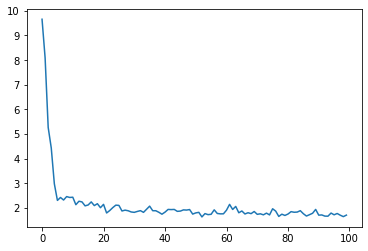

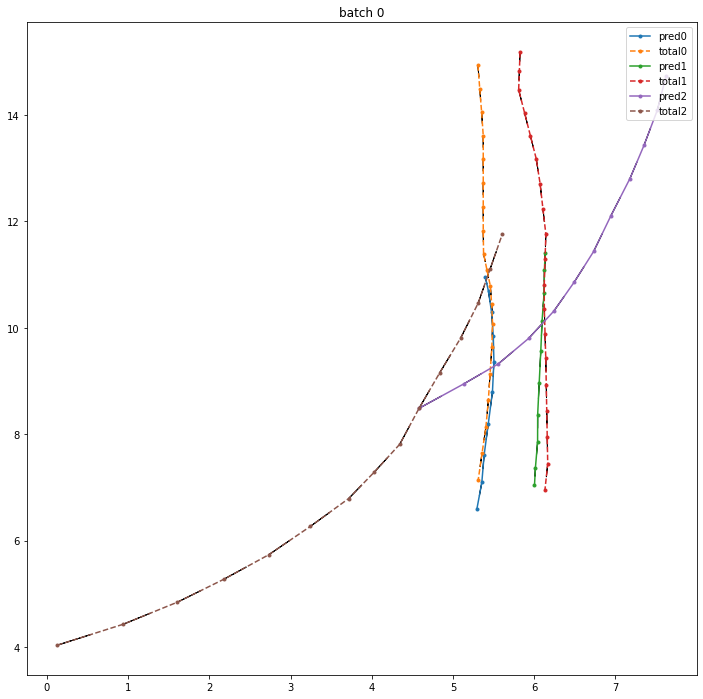

In [63]:
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"using {device}\n")
    vl = train(8, 20)
#     vl1 = torch.load("vl.pt")
    validate(vl, 8, 20)